#### Importing the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

#### Importing the data

In [3]:
df = pd.read_csv('Sample - Superstore Sales (Excel).csv',encoding='latin1')

In [5]:
df.head()

,Row ID,Order ID,Order Date,Month Year,Order Priority,Order Quantity,Sales,Customer Name,Province,Region,Product Category,Product Sub-Category,Product Name
0,1,3,10/13/2010,10-01-2010,Low,6,261.5400,Muhammed MacIntyre,Nunavut,Nunavut,Office Supplies,Storage & Organization,"Eldon Base for stackable storage shelf, platinum"
1,49,293,10-01-2012,10-01-2012,High,49,10123.0200,Barry French,Nunavut,Nunavut,Office Supplies,Appliances,"1.7 Cubic Foot Compact ""Cube"" Office Refrigera..."
2,50,293,10-01-2012,10-01-2012,High,27,244.5700,Barry French,Nunavut,Nunavut,Office Supplies,Binders and Binder Accessories,"Cardinal Slant-D® Ring Binder, Heavy Gauge Vinyl"
3,80,483,07-10-2011,07-01-2011,High,30,4965.7595,Clay Rozendal,Nunavut,Nunavut,Technology,Telephones and Communication,R380
4,85,515,8/28/2010,08-01-2010,Not Specified,19,394.2700,Carlos Soltero,Nunavut,Nunavut,Office Supplies,Appliances,Holmes HEPA Air Purifier


In [4]:
df.shape

(8399, 13)

### Question 2: Performing EDA

Performing basic check-ups before getting into solving the questions

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8399 entries, 0 to 8398
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Row ID                8399 non-null   int64  
 1   Order ID              8399 non-null   int64  
 2   Order Date            8399 non-null   object 
 3   Month Year            8399 non-null   object 
 4   Order Priority        8399 non-null   object 
 5   Order Quantity        8399 non-null   int64  
 6   Sales                 8399 non-null   float64
 7   Customer Name         8399 non-null   object 
 8   Province              8399 non-null   object 
 9   Region                8399 non-null   object 
 10  Product Category      8399 non-null   object 
 11  Product Sub-Category  8399 non-null   object 
 12  Product Name          8399 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 853.1+ KB


As we can see that data has no missing value and all the datatypes have been identified correctly

In [16]:
df.describe()

,Row ID,Order ID,Order Quantity,Sales
count,8399.000000,8399.000000,8399.000000,8399.000000
mean,4200.000000,29965.179783,25.571735,1775.878179
std,2424.726789,17260.883447,14.481071,3585.050525
min,1.000000,3.000000,1.000000,2.240000
25%,2100.500000,15011.500000,13.000000,143.195000
50%,4200.000000,29857.000000,26.000000,449.420000
75%,6299.500000,44596.000000,38.000000,1709.320000
max,8399.000000,59973.000000,50.000000,89061.050000


By the above count we can say that there are no missing values, and the mean of order quantity is 25 which is less than sales which is 1775.87189 , where the order quantity std is 14.48 and sales is 3585.05.

In [17]:
df.describe(include=object)

,Order Date,Month Year,Order Priority,Customer Name,Province,Region,Product Category,Product Sub-Category,Product Name
count,8399,8399,8399,8399,8399,8399,8399,8399,8399
unique,1418,48,5,795,13,8,3,17,1263
top,9/15/2011,01-01-2009,High,Darren Budd,Ontario,West,Office Supplies,Paper,"Global High-Back Leather Tilter, Burgundy"
freq,20,223,1768,41,1826,1991,4610,1225,24


**i) Average sales per customer**

In [8]:
df.groupby(['Customer Name'])['Sales'].mean().sort_values(ascending=False)

Customer Name
Craig Carreira       41343.2100
Emily Phan           11712.4438
Rick Reed            10696.1400
Ross DeVincentis      8527.9400
Clay Cheatham         8451.0336
                        ...    
Natalie DeCherney      125.9000
Katrina Edelman         90.3800
Eric Murdock            85.8320
Nicole Fjeld            76.5150
Jeremy Farry            42.8600
Name: Sales, Length: 795, dtype: float64

**Displaying the top 10 average sales customers(optional)**

<AxesSubplot:xlabel='Customer Name'>

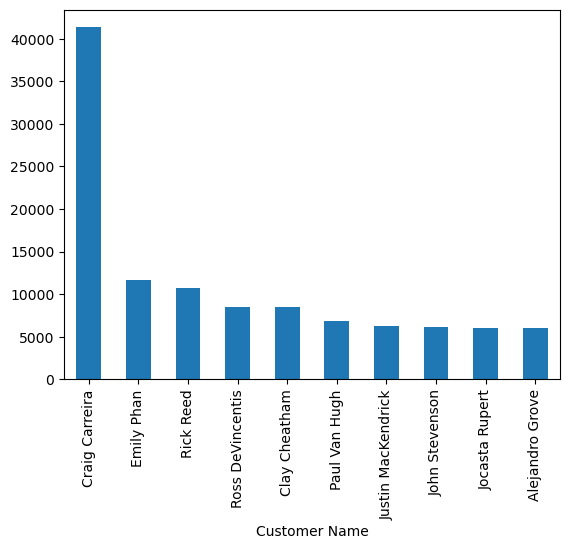

In [11]:
df.groupby(['Customer Name'])['Sales'].mean().sort_values(ascending=False).head(10).plot(kind='bar')

**As we can see that Craig Carreira has highest average sales compared to any other customers**

**ii) Average Transaction Size by product category**

Average transaction size by this I am I assuming your indicating the number transacation that took place for each product category

In [12]:
df.groupby(['Product Category']).size()

Product Category
Furniture          1724
Office Supplies    4610
Technology         2065
dtype: int64

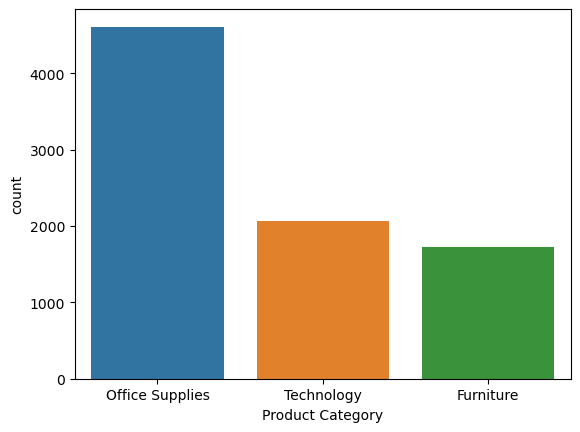

In [22]:
sns.countplot(df['Product Category'])
plt.show()

You can see that the office supplies is the product that has done a lot of transactions.

**Average sales region wise**

In [24]:
df.groupby(['Region'])['Sales'].mean()

Region
Atlantic                 1865.044633
Northwest Territories    2032.607435
Nunavut                  1473.120044
Ontario                  1677.553384
Prarie                   1663.132826
Quebec                   1933.668476
West                     1806.905713
Yukon                    1800.493304
Name: Sales, dtype: float64

<AxesSubplot:xlabel='Sales', ylabel='Region'>

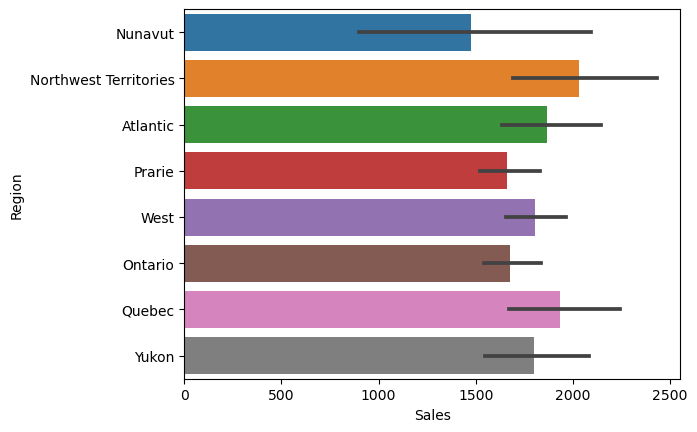

In [26]:
sns.barplot(df.Sales,df.Region)

You can see Northwest Territories has slightly highest average sales but key thing to note here is that Nunavut has lowest sales which needs to be looked into

### Calculating RFM

In [39]:
# let me convert the Order Date into Date type
df['Order Date'] = pd.DatetimeIndex(df['Order Date']).date


**RECENCY (R): Days since last purchase**

In [40]:
#last date available in our dataset

current_date = df['Order Date'].max()
current_date

datetime.date(2012, 12, 30)

I am considering the above current_date has my last date to calculate recency

In [41]:
recency_df = df.groupby(by='Customer Name', as_index=False)['Order Date'].max()
recency_df.columns = ['Customer Name','LastPurshaceDate']
recency_df.head(10)

,Customer Name,LastPurshaceDate
0,Aaron Bergman,2011-05-28
1,Aaron Hawkins,2011-12-29
2,Aaron Smayling,2012-01-19
3,Adam Bellavance,2012-10-02
4,Adam Hart,2012-12-11
5,Adam Shillingsburg,2011-08-11
6,Adrian Barton,2012-05-28
7,Adrian Hane,2012-06-12
8,Adrian Shami,2012-11-26
9,Aimee Bixby,2011-09-23


In [43]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (current_date - x).days)

In [45]:
recency_df

,Customer Name,LastPurshaceDate,Recency
0,Aaron Bergman,2011-05-28,582
1,Aaron Hawkins,2011-12-29,367
2,Aaron Smayling,2012-01-19,346
3,Adam Bellavance,2012-10-02,89
4,Adam Hart,2012-12-11,19
...,...,...,...
790,Vivian Mathis,2012-11-06,54
791,William Brown,2012-12-20,10
792,Xylona Price,2012-12-06,24
793,Yana Sorensen,2012-08-20,132


In [46]:
# Now that we calculated recency, we can drop LastPurshaceDate
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

In [47]:
recency_df

,Customer Name,Recency
0,Aaron Bergman,582
1,Aaron Hawkins,367
2,Aaron Smayling,346
3,Adam Bellavance,89
4,Adam Hart,19
...,...,...
790,Vivian Mathis,54
791,William Brown,10
792,Xylona Price,24
793,Yana Sorensen,132


**Frequency**

In [48]:
#calculate frequency of purchases
frequency_df = df.groupby(by=['Customer Name'], as_index=False)['Order Date'].count()
frequency_df.columns = ['Customer Name','Frequency']
frequency_df.head()

,Customer Name,Frequency
0,Aaron Bergman,7
1,Aaron Hawkins,12
2,Aaron Smayling,14
3,Adam Bellavance,12
4,Adam Hart,27


**Monetary**

In [50]:
monetary_df = df.groupby(by='Customer Name',as_index=False).agg({'Sales': 'sum'})
monetary_df.columns = ['Customer Name','Monetary']
monetary_df.head()

,Customer Name,Monetary
0,Aaron Bergman,11630.5900
1,Aaron Hawkins,27690.7255
2,Aaron Smayling,8835.3235
3,Adam Bellavance,11577.5800
4,Adam Hart,26114.2645


**RFM table**

In [51]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='Customer Name')
temp_df.head()

,Customer Name,Recency,Frequency
0,Aaron Bergman,582,7
1,Aaron Hawkins,367,12
2,Aaron Smayling,346,14
3,Adam Bellavance,89,12
4,Adam Hart,19,27


In [52]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='Customer Name')
#use CustomerID as index
rfm_df.set_index('Customer Name',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
Customer Name,,,
Aaron Bergman,582,7,11630.5900
Aaron Hawkins,367,12,27690.7255
Aaron Smayling,346,14,8835.3235
Adam Bellavance,89,12,11577.5800
Adam Hart,19,27,26114.2645


In [54]:
# Let's scale rfm dataframe for model to be more faster in computing.

In [57]:
X = pd.DataFrame(StandardScaler().fit_transform(rfm_df),columns=rfm_df.columns)

In [75]:
X

,Recency,Frequency,Monetary
0,1.510029,-0.588246,-0.446712
1,0.580134,0.236834,0.559329
2,0.489307,0.566867,-0.621813
3,-0.622242,0.236834,-0.450033
4,-0.924999,2.712075,0.460577
...,...,...,...
790,-0.773621,0.731883,0.667711
791,-0.963925,2.052011,1.259786
792,-0.903373,0.566867,-0.045395
793,-0.436263,-0.753262,-1.050797


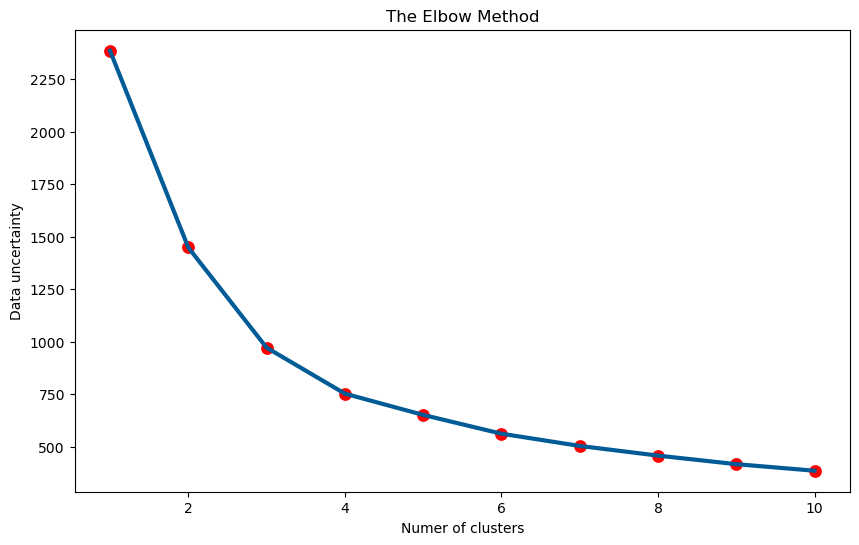

In [58]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit_predict(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
sns.scatterplot(x = range(1, 11), y = wcss, s= 100, color = 'red')
sns.lineplot(x = range(1,11), y = wcss, linewidth = 3, color = '#005b96')
plt.title('The Elbow Method')
plt.xlabel('Numer of clusters')
plt.ylabel('Data uncertainty')
plt.show()

From the above Elbow plot we can say that 3 or 4 are the optical cluster size. Let's try with silhouette score

In [62]:
range_n_clusters = [2,3,4,5,6,7,8,9,10]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.3746257161694893
For n_clusters = 3 The average silhouette_score is : 0.3860165564609586
For n_clusters = 4 The average silhouette_score is : 0.34851262522517457
For n_clusters = 5 The average silhouette_score is : 0.30869183962415614
For n_clusters = 6 The average silhouette_score is : 0.29655056426170984
For n_clusters = 7 The average silhouette_score is : 0.28471025011944545
For n_clusters = 8 The average silhouette_score is : 0.27177071040211376
For n_clusters = 9 The average silhouette_score is : 0.28002020018801954
For n_clusters = 10 The average silhouette_score is : 0.2833117612428342


Now we can see that 3 would be the optimal cluster. So let's go ahead with cluester 3

In [63]:
kmeans = KMeans(n_clusters = 3)
y_kmeans = kmeans.fit_predict(X)

In [103]:
X['Labels'] = y_kmeans

<AxesSubplot:xlabel='Recency', ylabel='Frequency'>

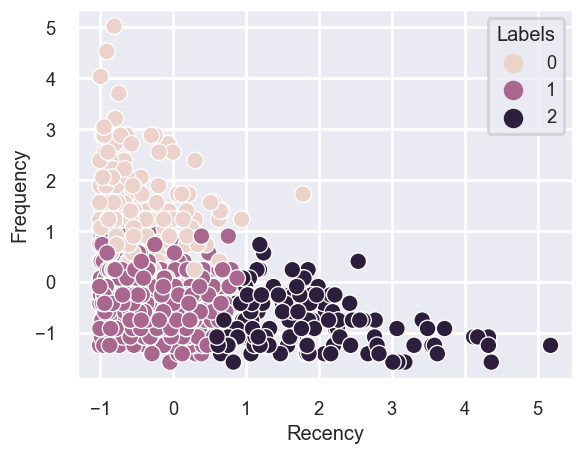

In [104]:
sns.scatterplot(X.Recency,X.Frequency,hue=X.Labels)

<AxesSubplot:xlabel='Recency', ylabel='Monetary'>

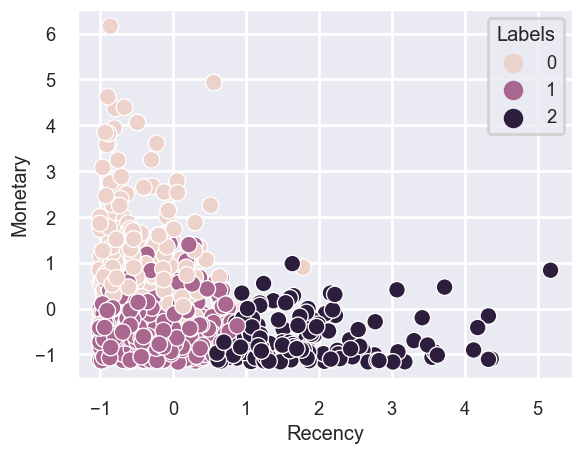

In [105]:
sns.scatterplot(X.Recency,X.Monetary,hue=X.Labels)

<AxesSubplot:xlabel='Frequency', ylabel='Monetary'>

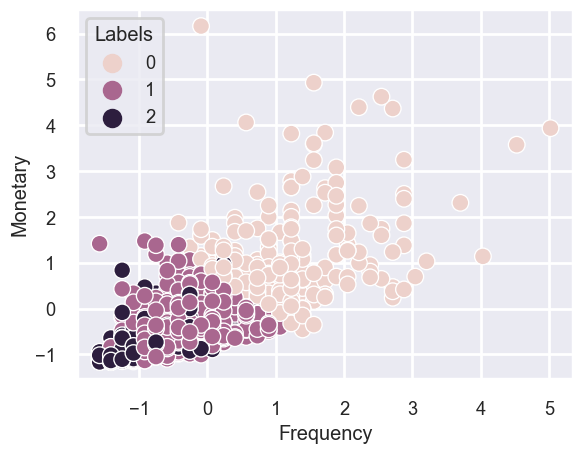

In [106]:
sns.scatterplot(X.Frequency,X.Monetary,hue=X.Labels)

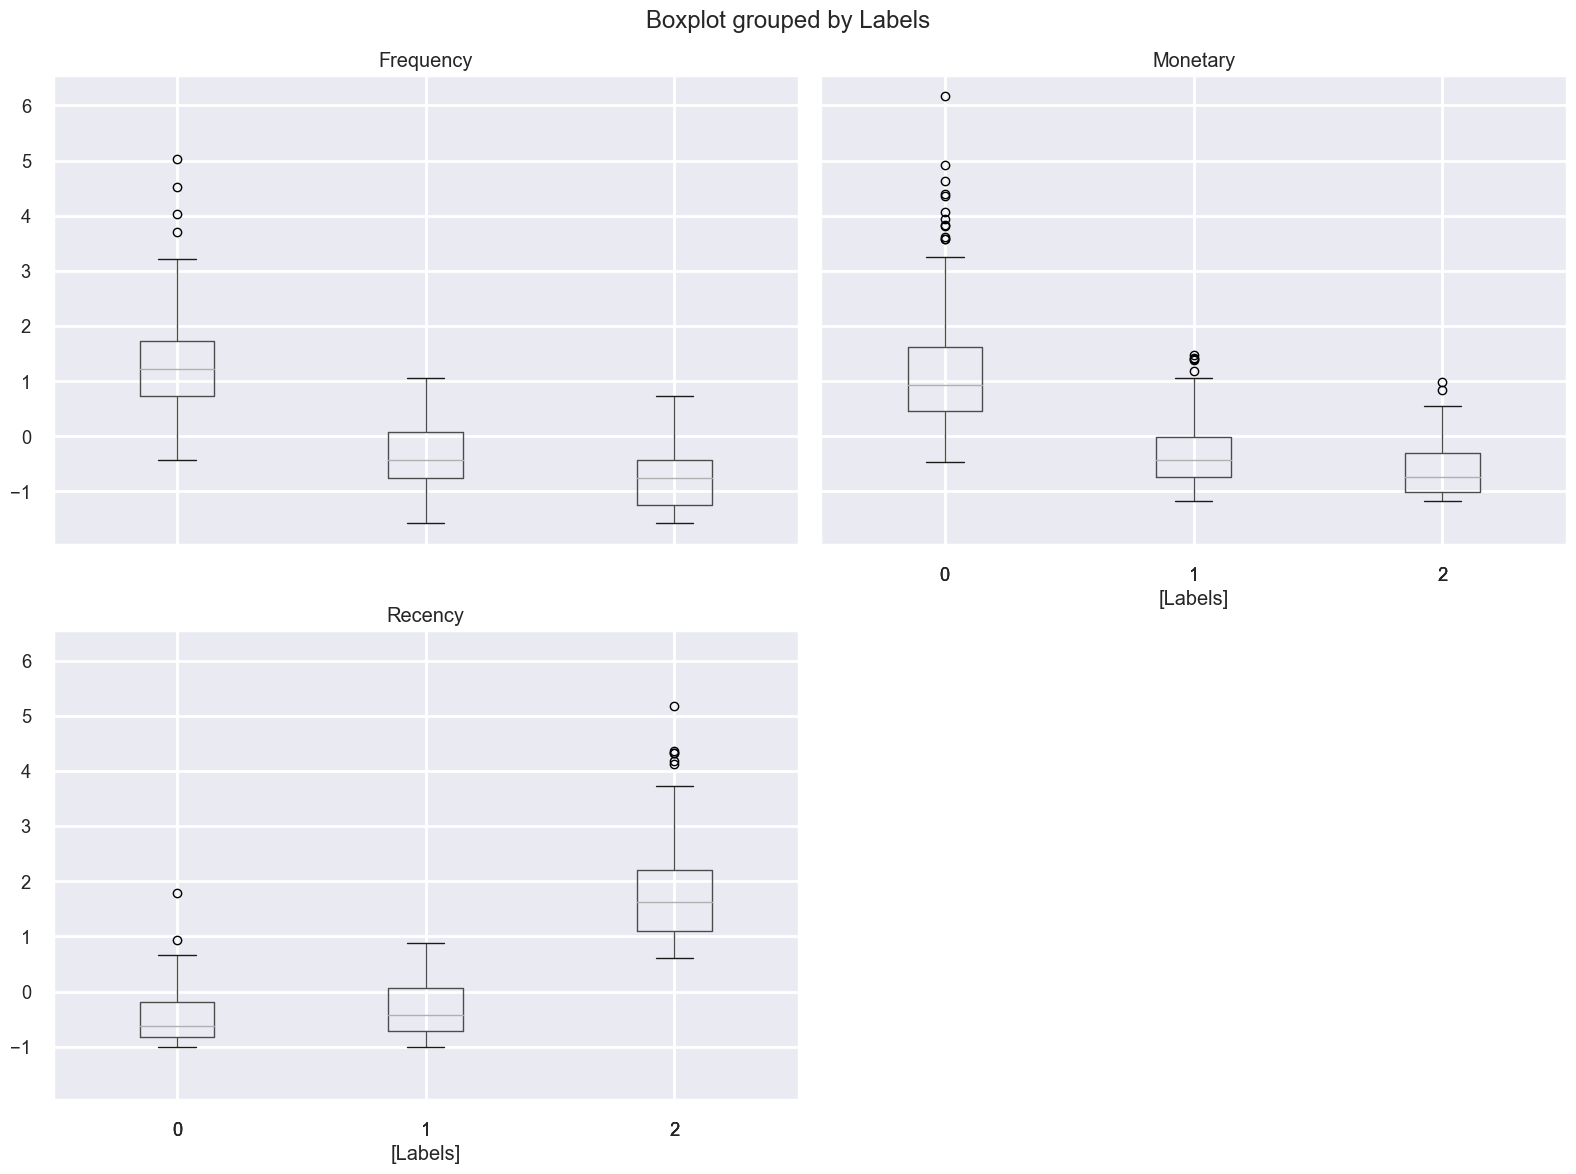

In [111]:
X.boxplot(by="Labels",figsize=(16,12))
plt.tight_layout()

In [112]:
rfm_df['Labels'] = y_kmeans

In [115]:
rfm_df[rfm_df['Labels']==0].describe()

,Recency,Frequency,Monetary,Labels
count,205.000000,205.000000,205.000000,205.0
mean,123.712195,18.356098,37941.091954,0.0
std,105.711595,5.350923,17213.526931,0.0
min,0.000000,8.000000,11448.060000,0.0
25%,42.000000,15.000000,26217.903500,0.0
50%,89.000000,18.000000,33724.735500,0.0
75%,188.000000,21.000000,44571.925000,0.0
max,645.000000,41.000000,117124.438000,0.0


In [116]:
rfm_df[rfm_df['Labels']==1].describe()

,Recency,Frequency,Monetary,Labels
count,455.000000,455.000000,455.000000,455.0
mean,158.294505,8.450549,13041.592096,1.0
std,110.281364,3.194377,8263.474433,0.0
min,0.000000,1.000000,85.720000,1.0
25%,67.500000,6.000000,6896.326500,1.0
50%,134.000000,8.000000,11861.512000,1.0
75%,246.000000,11.000000,18420.670000,1.0
max,436.000000,17.000000,42255.168000,1.0


In [117]:
rfm_df[rfm_df['Labels']==2].describe()

,Recency,Frequency,Monetary,Labels
count,135.000000,135.000000,135.000000,135.0
mean,649.962963,5.859259,8916.685704,2.0
std,215.775014,3.059517,7613.996077,0.0
min,372.000000,1.000000,125.900000,2.0
25%,486.000000,3.000000,2774.500000,2.0
50%,607.000000,6.000000,6970.430000,2.0
75%,740.500000,8.000000,13847.101250,2.0
max,1430.000000,15.000000,34398.050000,2.0


i) As we can cluster 0 recency is very low compared to other clusters customers.
ii) And you can also see that cluster 0 frequency is high
iii) And you can see that Monetary is very high for cluster 0

These things indicates that customers how belogs to the cluster 0 are the golden customers. because they are frequent in terms of ordering products, they are also very recency in nature, and they spend a lot compared to others.